In [39]:
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

from tqdm import tqdm_notebook

from mhrw.mhrw_base import MHRW
from mhrw.utils import start_session

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
def degree_cdf(graph_neigh, k_range):
    degree_dist = np.zeros_like(k_range)
    count = graph_neigh.count()
    
    for i, k in enumerate(tqdm_notebook(k_range)):
        degree_k = graph_neigh.filter(f"degree <= {k}").count()
        degree_dist[i] = degree_k
    
    return degree_dist / count

def process_fb(path, save_path=None, to_undirected=False, compression="UNCOMPRESSED"):
    get_edges = lambda row: row.split()[:2]
    head = lambda itr, i: [next(itr) for _ in range(i)]
    
    with open(path, "r") as file:
        edge_list = map(get_edges, file)
        header = head(edge_list, 2)

        df = pd.DataFrame(edge_list, columns=["user", "item"]).drop_duplicates()
        df = df.astype({"user": "int64", "item": "int64"})
        
        if to_undirected:
            df_inv = df.rename(columns={"user": "item", "item": "user"})
            df = df.append(df_inv)
        
        if save_path:
            df.to_parquet("data/fb_edge_list", index=False, compression="UNCOMPRESSED")
    
    return df

# Network data

[Facebook friendship graph](http://networkrepository.com/fb-wosn-friends.php) where nodes are users and edges between the users represent friendship relations/edges. 

In [29]:
%%time
df = process_fb("data/fb-wosn-friends.edges", "data/fb_edge_list")

CPU times: user 4.93 s, sys: 557 ms, total: 5.49 s
Wall time: 7.24 s


# Sampling

In [3]:
spark, sc = start_session("test_sample")

import pyspark.sql.functions as F

In [4]:
graph = spark.read.parquet("data/fb_edge_list")

In [5]:
graph_neig = graph.groupBy("user").agg(F.collect_list("item").alias("neigh"))

In [9]:
MHRW(graph_neig, "data/sampled_ids", seed_ratio=0.03, accept_func="RCMH", alpha=0.3)

INFO - 2019-09-15 17:40:08: sampled 1316 seed nodes, budget: 4509
INFO - 2019-09-15 17:40:29: iteration 1, sampled 2216 nodes, progress: 49.15%
INFO - 2019-09-15 17:41:01: iteration 2, sampled 2906 nodes, progress: 64.45%
INFO - 2019-09-15 17:41:58: iteration 3, sampled 3385 nodes, progress: 75.07%
INFO - 2019-09-15 17:42:46: iteration 4, sampled 3718 nodes, progress: 82.46%
INFO - 2019-09-15 17:43:47: iteration 5, sampled 3945 nodes, progress: 87.49%
INFO - 2019-09-15 17:44:51: iteration 6, sampled 4103 nodes, progress: 91.0%
INFO - 2019-09-15 17:45:51: iteration 7, sampled 4201 nodes, progress: 93.17%
INFO - 2019-09-15 17:46:57: iteration 8, sampled 4267 nodes, progress: 94.63%
WARNING - 2019-09-15 17:48:20: gain lower than 1 percent, stop sampling!


# Node Degree Distribution 

In [55]:
from mhrw.utils import arr_len
from mhrw.utils import graph_filter_ids

In [46]:
k_range = np.arange(1, 80, 2.5)

In [50]:
graph_neig = graph_neig.withColumn("degree", arr_len("neigh"))
graph_random = graph_neig.sample(False, 0.1, seed=42)

In [59]:
sampled_ids = spark.read.parquet("data/sampled_ids").distinct().withColumnRenamed("user", "user_id")
graph_mhrw = graph_filter_ids(graph, sampled_ids)

graph_mhrw = (graph_mhrw
              .groupBy("user")
              .agg(F.collect_list("item").alias("neigh"))
              .withColumn("degree", arr_len("neigh"))).persist()

In [60]:
base_ndd = degree_cdf(graph_neig, k_range)
random_ndd = degree_cdf(graph_random, k_range)
mhrw_ndd = degree_cdf(graph_mhrw, k_range)

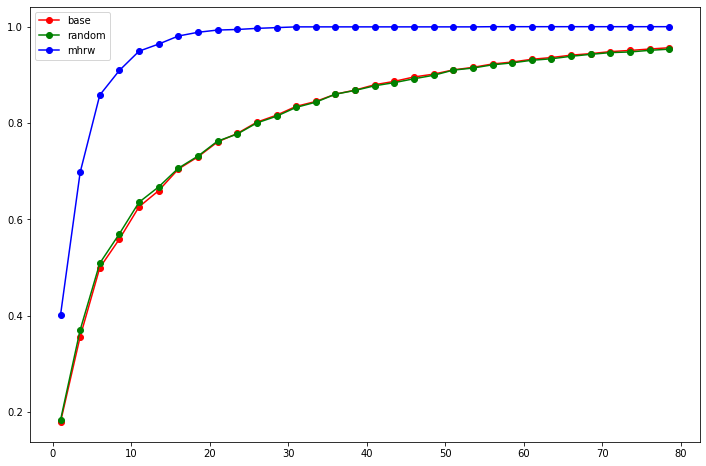

In [63]:
plt.figure(figsize=(12, 8))
plt.plot(k_range, base_ndd, marker='o', color="red", label="base");
plt.plot(k_range, random_ndd, marker='o', color="green", label="random");
plt.plot(k_range, mhrw_ndd, marker='o', color="blue", label="mhrw");
plt.legend();